### Model Training Pipeline

This notebook retrains the model and saves the model and performance metrics (Accuracy and AUC) to the Hopsworks.ai Model Registry.

It executes Notebook 07 as part of the process and will use parameters as set there (GPU/no GPU, retune Hyperparameters or not, etc...). 

Notebook 07 is executed as a subprocess and the output is captured and displayed in this notebook. Notebook 07 is used instead of full conversion to py scripts because, while Neptune.ai experiment tracking is integrated in, I like to be able to also review the output in the notebook as well.


This Notebook does the following:
 - Retrieves a train and test dataset from the Feature Store based upon on how many DAYS back from today you want to use as the test dataset.
 - Saves theses datasets as csv files in the data directory where Notebook 07 will expect to find them.
 - Executes Notebook 07 as a subprocess and captures the output.
 - Saves the model and performance metrics to the Hopsworks.ai Model Registry.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np

import hopsworks

from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from hsfs.client.exceptions import RestAPIError

import json

from datetime import datetime, timedelta

# change working directory to project root when running from notebooks folder to make it easier to import modules
# and to access sibling folders
os.chdir('..') 

from pathlib import Path  #for Windows/Linux compatibility


from src.utils.hopsworks_utils import (
    convert_feature_names,
    create_train_test_data,
)

from dotenv import load_dotenv


/home/vboxuser/.cache/pypoetry/virtualenvs/basketball-prediction-oUm1FXwM-py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/vboxuser/Projects/basketball-prediction/configs


In [3]:
CONFIGS_PATH = Path.cwd() / "configs"
DATA_PATH = Path.cwd() / "data"
NOTEBOOKS_PATH = Path.cwd() / "notebooks"
MODELS_PATH = Path.cwd() / "models"

**Parameters**

Train and Test will be divided by date. The earliest chunk of data will be used as the train dataset and the last DAYS of data will be used as the test dataset.

STARTDATE: The date to start the train dataset from. The train dataset will compose of all data from this date forward, leaving out the last number of DAYS as the test dataset.

DAYS: The number of days to use as the test dataset. The test dataset will be the last DAYS days of data.

In [4]:
STARTDATE = "2003-01-01" # start date "YYYY-MM-DD" for training data, data goes back to 2003 season "2003-01-01"
DAYS = 30 # number of most recent days to use as test data

In [5]:
try:
    HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')
except:
    raise Exception('Set environment variable HOPSWORKS_API_KEY')

**Connect to Hopsworks FeatureStore and Pull Train and Test data**

In [33]:
train, test = create_train_test_data(HOPSWORKS_API_KEY, STARTDATE, DAYS)

/home/vboxuser/Projects/basketball-prediction/configs
Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/90261
Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/90261/fs/90180/fv/rolling_stats_fv/version/2
Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/90261/jobs/named/rolling_stats_fv_2_create_fv_td_16092023151754/executions


**Save data**

As a convenience to re-use the existing model training notebook, the data is saved to files first (currently <100 megabytes total)

In [34]:
train.to_csv(DATA_PATH / "processed" / "train_selected.csv",index=False)
test.to_csv(DATA_PATH / "processed" / "test_selected.csv",index=False)

**Model Training**

The existing model training notebook is re-used. It includes Neptune.ai experiment tracking for both training run and hyperparameter tuning.


XGB version: 1.6.0
LGB version: 3.3.2
https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-55
https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-56


[I 2023-09-16 17:37:23,415] A new study created in memory with name: no-name-77e70776-dd93-4d47-9b1a-4f8c90e06102
[I 2023-09-16 17:37:26,539] Trial 0 finished with value: 0.6233175286581973 and parameters: {'lambda_l1': 0.048007102021552145, 'lambda_l2': 2.922799359842082, 'learning_rate': 0.014845118088611367, 'max_depth': 40, 'n_estimators': 298, 'feature_fraction': 0.980041725296143, 'bagging_fraction': 0.8097328213694072, 'bagging_freq': 3, 'num_leaves': 209, 'min_child_samples': 246, 'min_data_per_groups': 30}. Best is trial 0 with value: 0.6233175286581973.
[I 2023-09-16 17:37:30,083] Trial 1 finished with value: 0.6245873275337724 and parameters: {'lambda_l1': 0.011601313902624888, 'lambda_l2': 2.0546695547165284e-07, 'learning_rate': 0.05369450903595373, 'max_depth': 100, 'n_estimators': 202, 'feature_fraction': 0.4415685491843647, 'bagging_fraction': 0.6513011970187028, 'bagging_freq': 5, 'num_leaves': 608, 'min_child_samples': 159, 'min_data_per_groups': 63}. Best is trial 1 

Study Best Value: 0.6245873275337724
Study Best Params: {'lambda_l1': 0.011601313902624888, 'lambda_l2': 2.0546695547165284e-07, 'learning_rate': 0.05369450903595373, 'max_depth': 100, 'n_estimators': 202, 'feature_fraction': 0.4415685491843647, 'bagging_fraction': 0.6513011970187028, 'bagging_freq': 5, 'num_leaves': 608, 'min_child_samples': 159, 'min_data_per_groups': 63}
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
All 17 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-56/metadata


0it [00:00, ?it/s]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


1it [00:19, 19.68s/it]


Scores:

Accuracy Score: 0.6265377855887522
AUC Score: 0.6339553674490188
Optimal Threshold: 0.49429351885911355
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


2it [00:20,  8.42s/it]


Scores:

Accuracy Score: 0.6186291739894552
AUC Score: 0.6516313407954275
Optimal Threshold: 0.6035385468261186
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
2023-09-16 17:38:31,194 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 0.0
2023-09-16 17:38:31,217 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 1.0
2023-09-16 17:38:31,217 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 2.0
2023-09-16 17:38:31,218 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 3.0
2023-09-16 17:38:31,218 ERROR: Error occurred during asynchrono

3it [00:22,  5.41s/it]


Scores:

Accuracy Score: 0.6432337434094904
AUC Score: 0.6568567419313689
Optimal Threshold: 0.5430817538068963
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


4it [00:22,  3.60s/it]


Scores:

Accuracy Score: 0.6203866432337434
AUC Score: 0.6602350196487136
Optimal Threshold: 0.6142146909408818
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


5it [00:23,  4.77s/it]


Scores:

Accuracy Score: 0.6353251318101933
AUC Score: 0.6583153347732181
Optimal Threshold: 0.5593386788045761

Scores:

Accuracy Score: 0.5951683748169839
AUC Score: 0.6076241384708659
Optimal Threshold: 0.5369575674980751
CPU times: user 2min 29s, sys: 0 ns, total: 2min 29s
Wall time: 24 s
[[1706 1107]
 [1658 2359]]
              precision    recall  f1-score   support

           0       0.51      0.61      0.55      2813
           1       0.68      0.59      0.63      4017

    accuracy                           0.60      6830
   macro avg       0.59      0.60      0.59      6830
weighted avg       0.61      0.60      0.60      6830



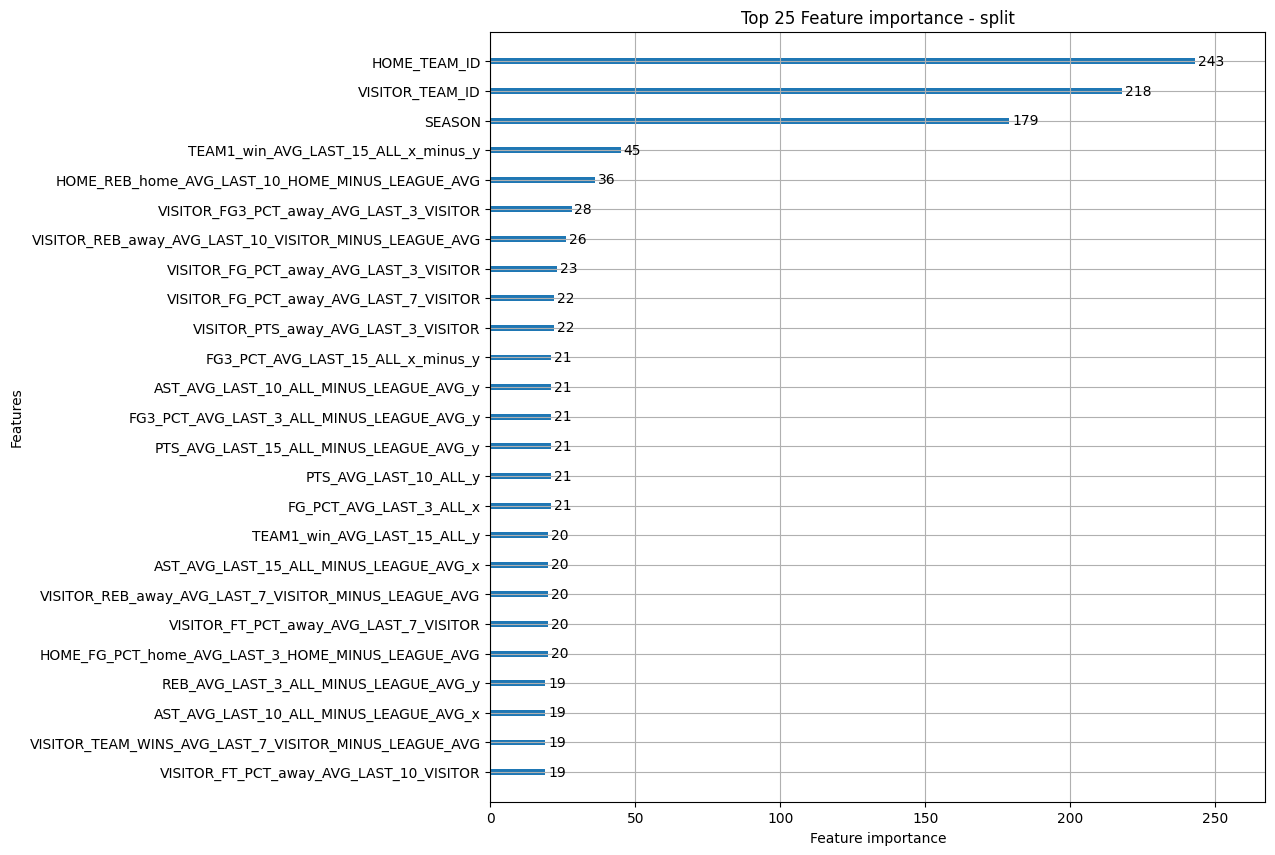

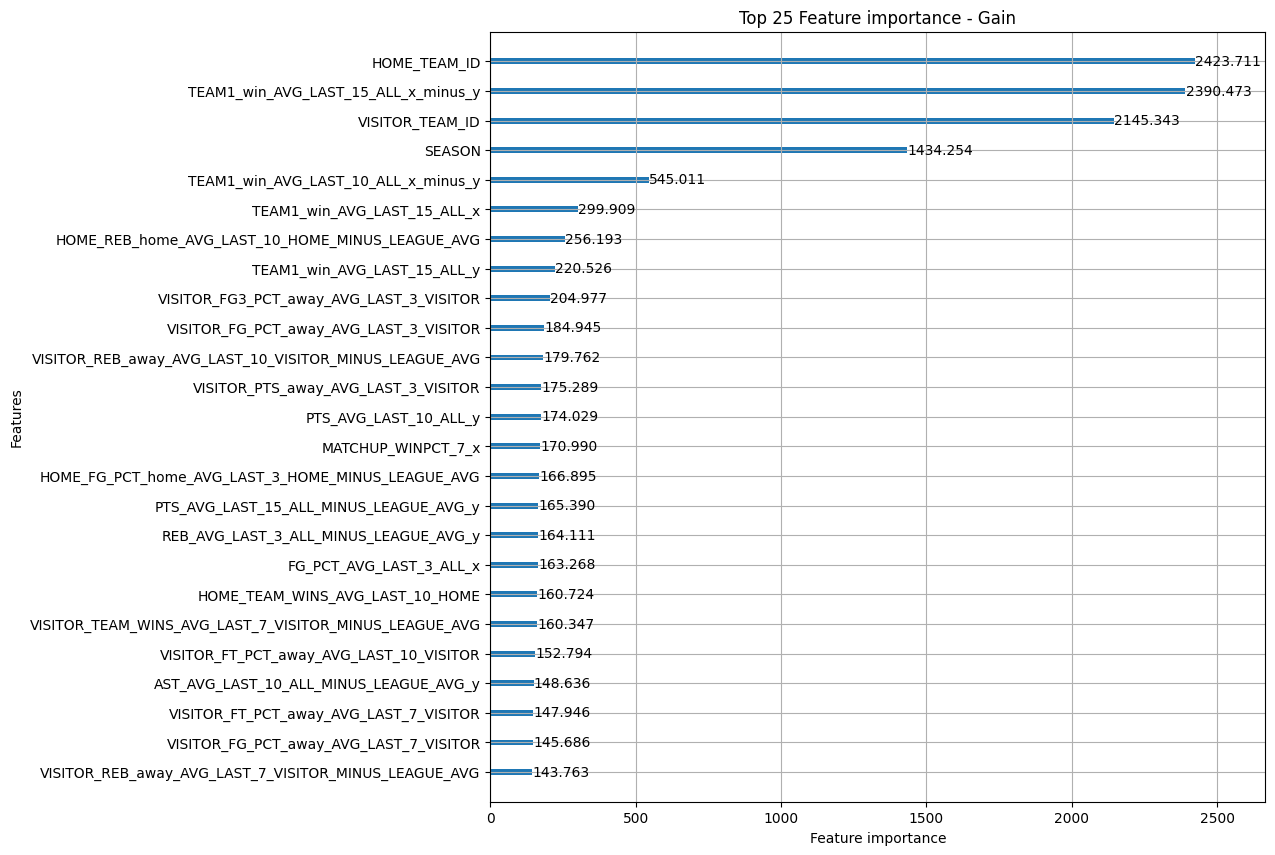

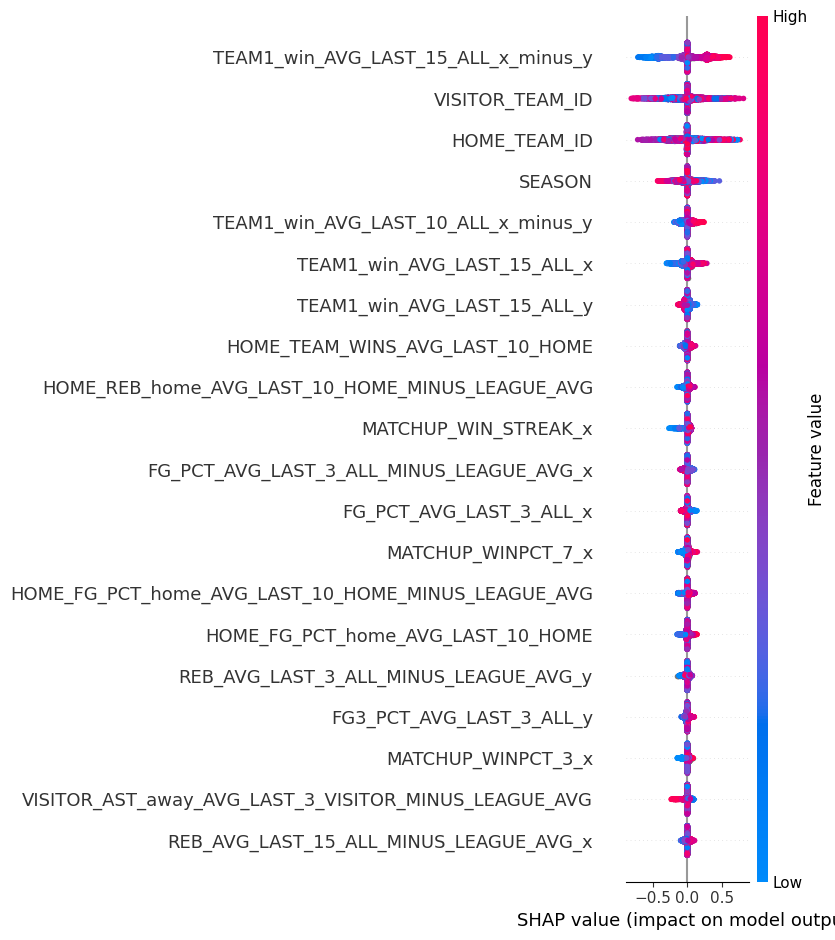

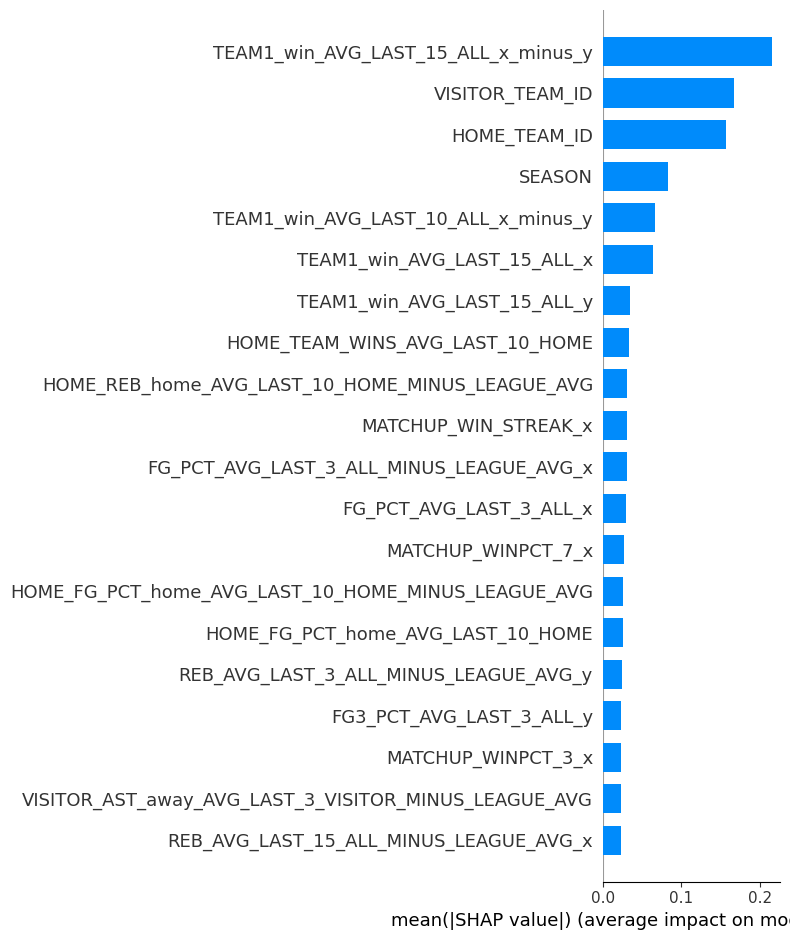

2023-09-16 17:38:37,767 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 155.0
2023-09-16 17:38:37,773 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 156.0
2023-09-16 17:38:37,777 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 157.0
2023-09-16 17:38:37,778 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 158.0
2023-09-16 17:38:37,779 ERROR: Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 159.0
2023-09-16 17:38:37,787 ERROR: Erro

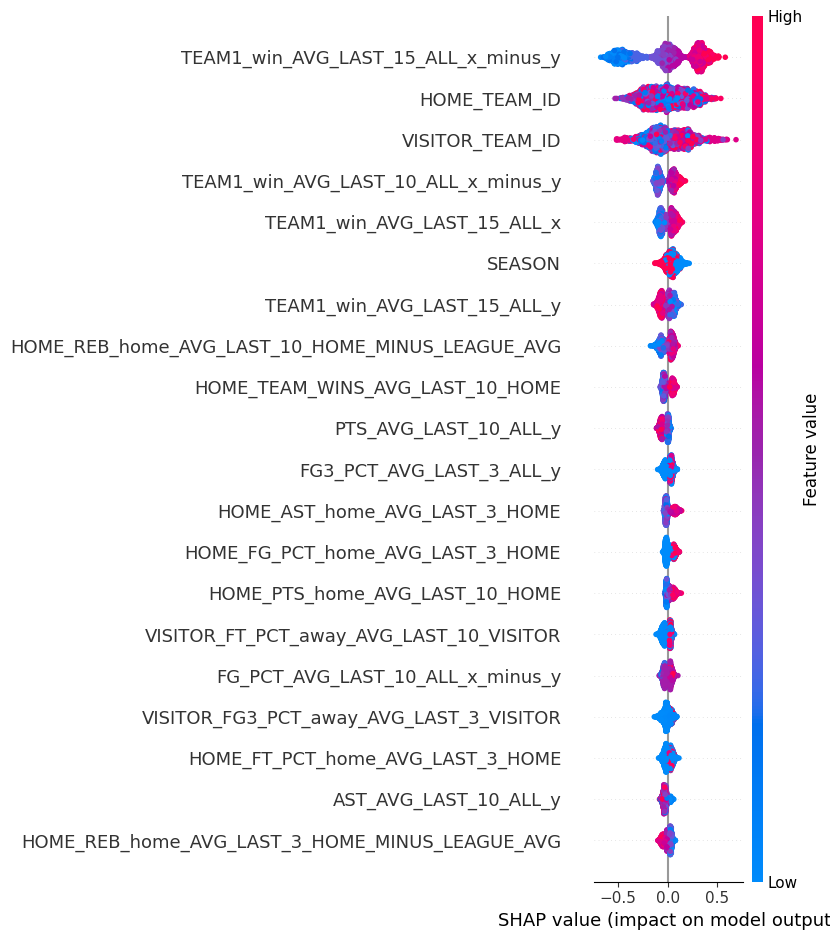

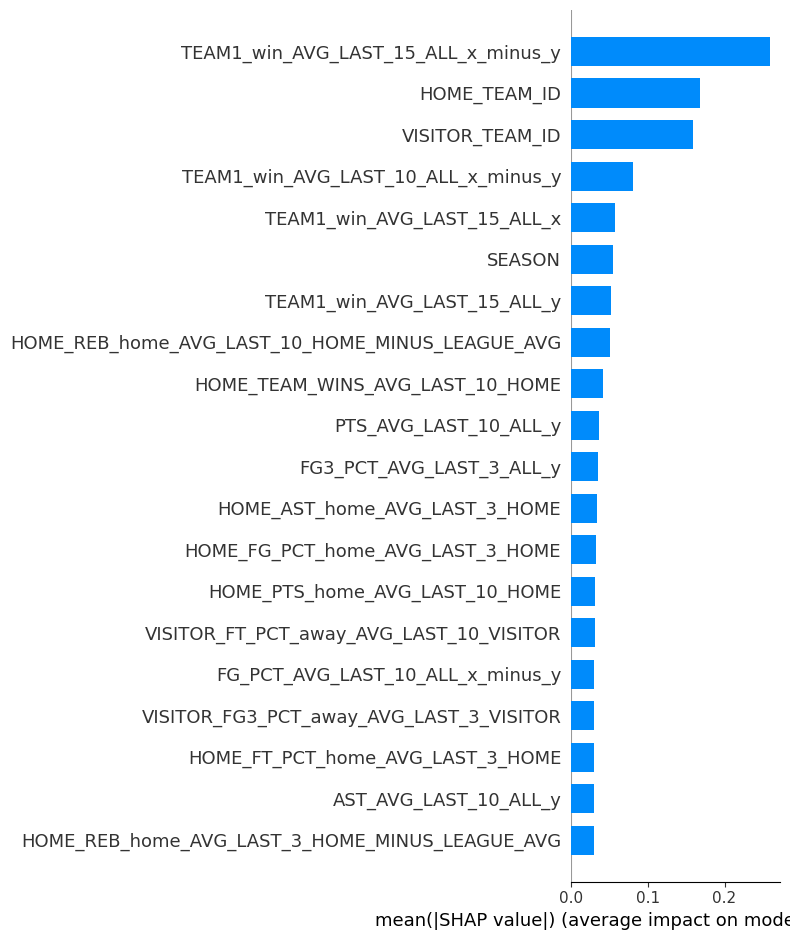

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10081 entries, 9423 to 1300
Columns: 245 entries, GAME_DATE_EST to REB_AVG_LAST_15_ALL_x_minus_y
dtypes: datetime64[ns](1), float16(222), int16(5), int32(1), int8(16)
memory usage: 4.7 MB
TEST1

Scores:

Accuracy Score: 0.68743798372693
AUC Score: 0.743527373247648
Optimal Threshold: 0.5727746313024314
              precision    recall  f1-score   support

           0       0.61      0.67      0.64      2068
           1       0.75      0.70      0.72      2971

    accuracy                           0.69      5039
   macro avg       0.68      0.69      0.68      5039
weighted avg       0.69      0.69      0.69      5039



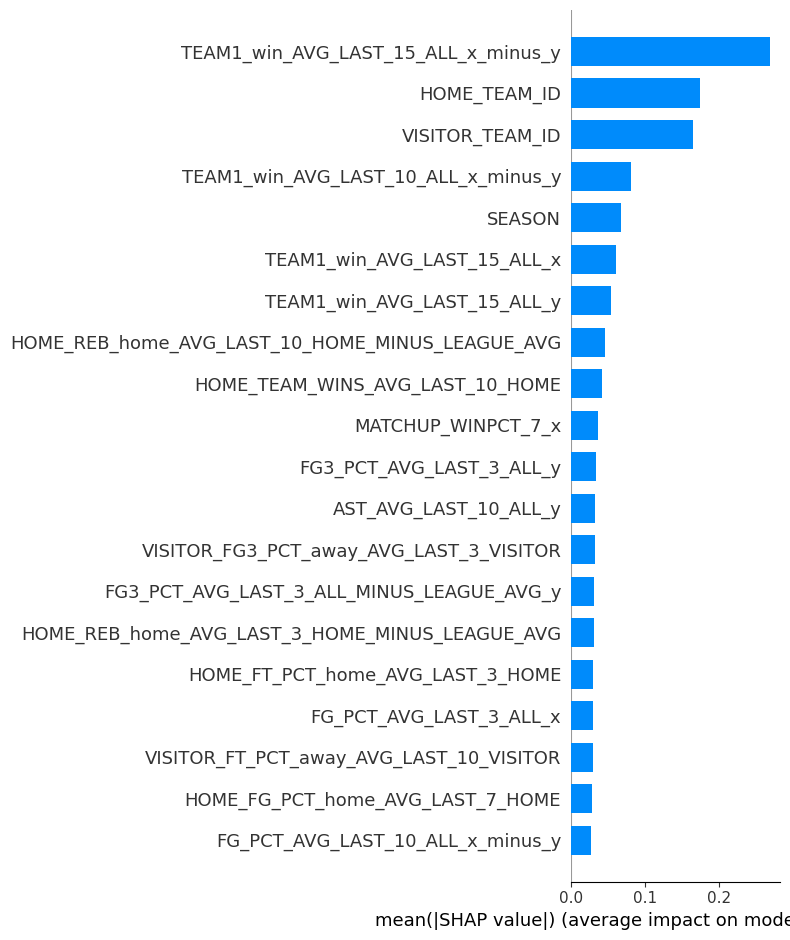

TEST2

Scores:

Accuracy Score: 0.6451804839349464
AUC Score: 0.691575981220777
Optimal Threshold: 0.5656160826196373
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      2230
           1       0.68      0.68      0.68      2812

    accuracy                           0.65      5042
   macro avg       0.64      0.64      0.64      5042
weighted avg       0.64      0.65      0.65      5042



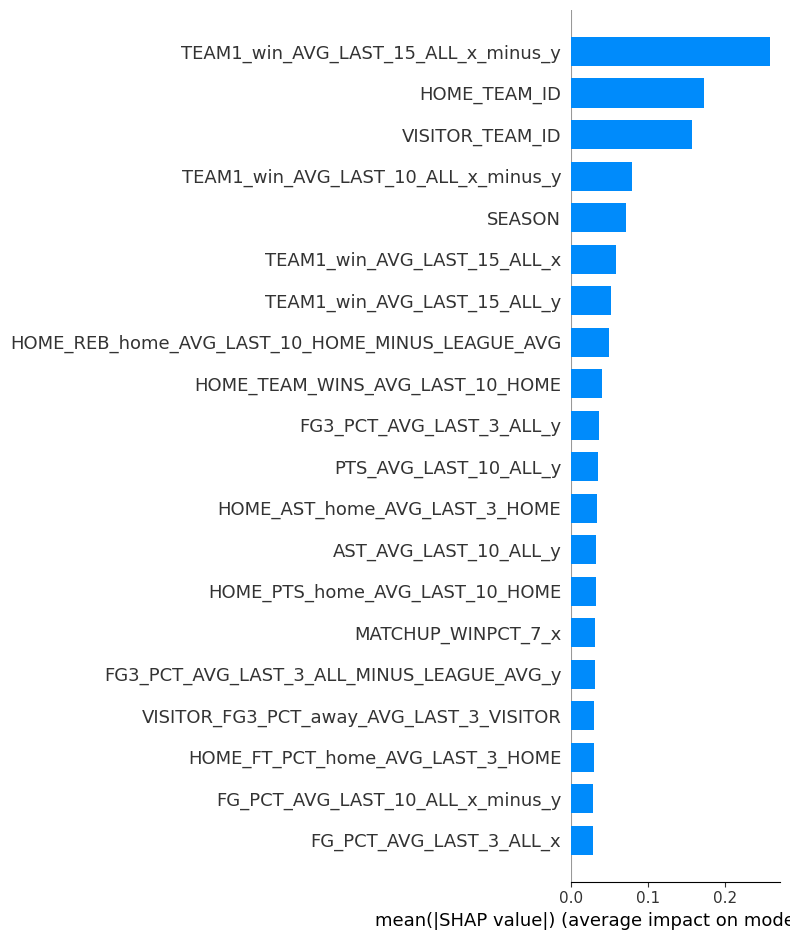

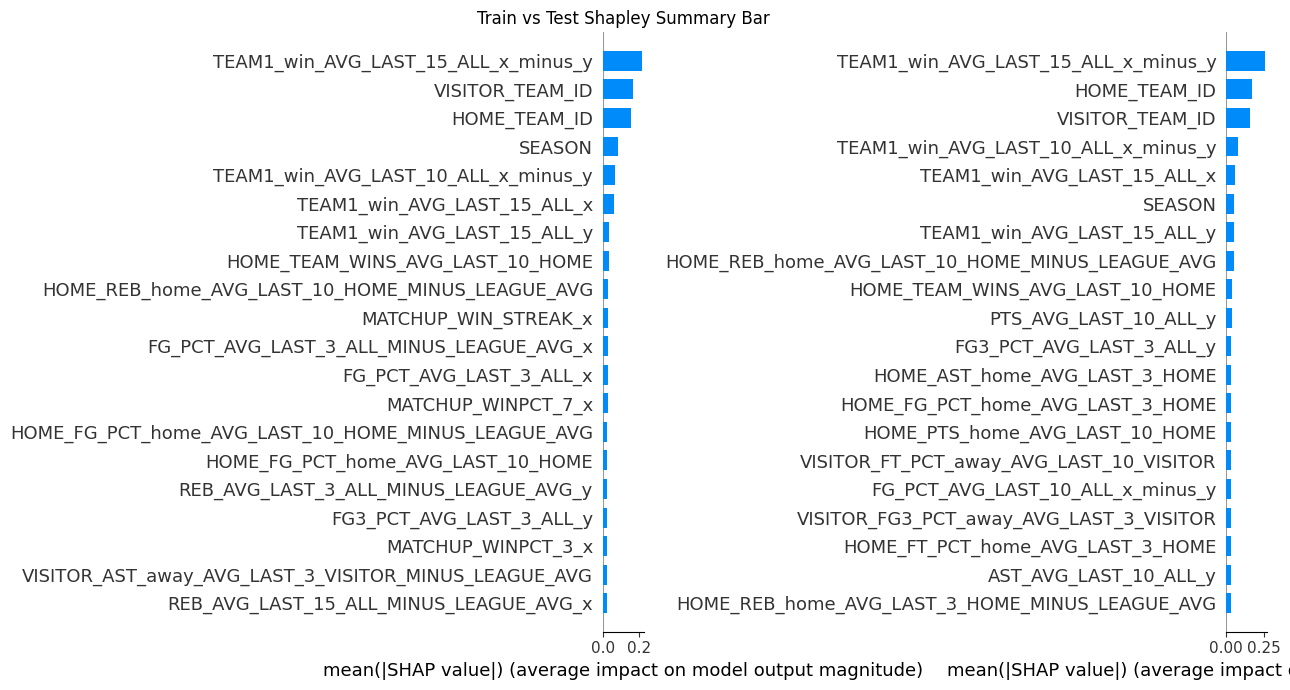

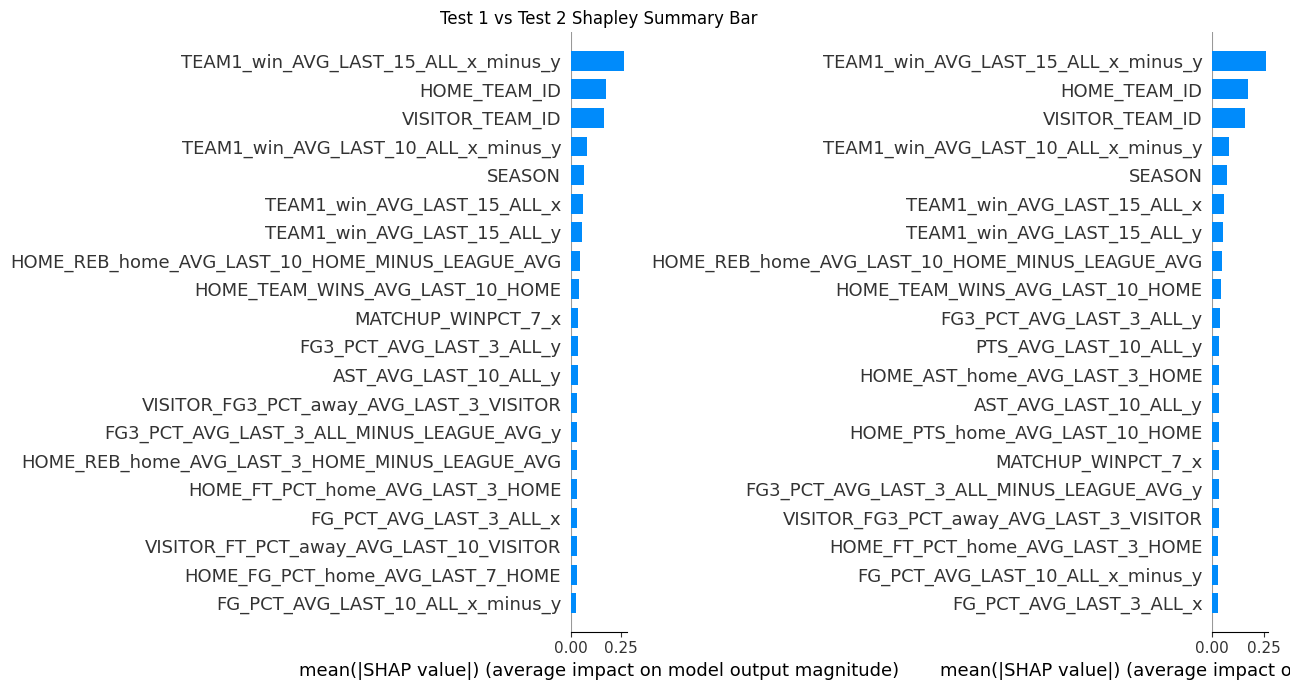

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-55/metadata
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.4415685491843647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4415685491843647
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.0546695547165284e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0546695547165284e-07
[LightGBM] [Warning] bagging_fraction is set=0.6513011970187028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6513011970187028
[LightGBM] [Warning] lambda_l1 is set=0.011601313902624888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0

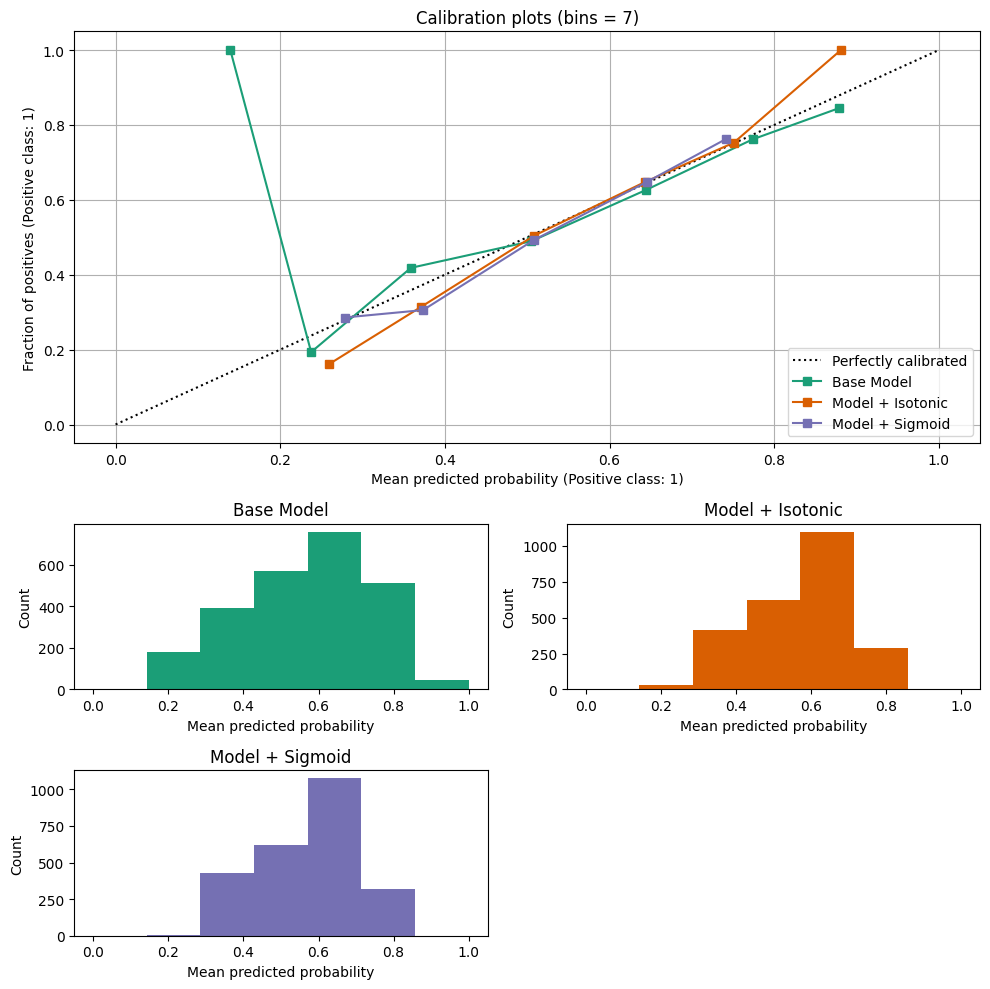

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.4415685491843647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4415685491843647
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.0546695547165284e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0546695547165284e-07
[LightGBM] [Warning] bagging_fraction is set=0.6513011970187028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6513011970187028
[LightGBM] [Warning] lambda_l1 is set=0.011601313902624888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011601313902624888
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.4415685491843647, colsample_bytree=1.0 

In [36]:
%run notebooks/07_model_testing.ipynb


**Save to Model Registry**



In [42]:
project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


ModelRegistry(project: 'nba_match_prediction')

In [47]:
# read in train_predictions to create model schema
train = pd.read_csv(DATA_PATH / "processed" / "train_predictions.csv")
target = train['TARGET']
drop_columns = ['TARGET', 'PredictionPct', 'Prediction']
train = train.drop(columns=drop_columns)

input_schema = Schema(train)
output_schema = Schema(target)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
model_schema.to_dict()

# read in model meta_data from training run
with open(MODELS_PATH / 'model_data.json', 'rb') as fp:
    model_data = json.load(fp)
    

# # log back in to hopsworks.ai. Hyperparameter tuning may take hours.
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
mr = project.get_model_registry()

model = mr.sklearn.create_model(
    name = model_data['model_name'],
    # metrics = model_data['metrics'],
    description = (model_data['model_name'] + ", calibration_method: " + model_data['calibration_method'] + ", brier_loss: " + str(model_data['brier_loss'])), 
    model_schema = model_schema
)
model.save(MODELS_PATH / 'model.pkl')


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/90261
Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:31<00:00,  5.33s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/90261/models/lightgbm/1


Model(name: 'lightgbm', version: 1)